# World Data League 2021

## External links and resources
Repository with all of the used data sources - https://github.com/lb4rcella/Sustainable-DTrees-Data/tree/master/Stage_3

## Introduction
We approached the problem with an extensive data analysis from 4 slightly different perspectives. With these we hope to look at the problem from different angles, combining the insights to have stronger and well-grounded improvement proposals:
- Study the distance from each Lisbon district centroid to its closest cycling way. Since this is the most dense region of the city (it's weighted by the population), it makes sense to have cycling ways close to these points
- Study the coverage of the cycling ways from the perspective of the GIRA shared bike stations (data from http://dados.cm-lisboa.pt/dataset/giras-docas/resource/c5c9e585-8990-4e19-a720-5c0ac3191705)
- Model the problem with a graph and study the reachibility of the different edges (edges connect districts if there is a cycling road connecting the two in an adjacent way)
- Study the correlation of the presence of cycling roads and the mobility data figures

From this analysis we can derive a set of concrete measures that target the most pressing issues discovered, providing a clear and straightforward solution that can allow for the missing links to be built and to extend the current network.

This notebook provides a framework of practical analysis that should be done when studying ways to extend existing cycling roads, applicable to any city with the proper data available.

## Development

## 1 - Understand cycling road presence and mobility patterns between districts

In [1]:
import pandas as pd
import numpy as np
import geojson
import geopandas
import json
import random
import networkx as nx
import ast
import plotly.graph_objects as go
import plotly.express as px
from haversine import haversine
from statistics import mean
from shapely.geometry import MultiPolygon, Polygon, MultiLineString, LineString
import itertools
import matplotlib.pyplot as plt

DATA_DIR = "../data/"

In [2]:
dicofre_translate = pd.read_csv(DATA_DIR+"dicofre_translation_table.csv")
with open(DATA_DIR+"LisbonCyclingNetwork.geojson") as f:
    cycling_network = geojson.load(f)
with open(DATA_DIR+"LisbonDistricts_Geom_Population.geojson") as f:
    lisbon_geometry = geojson.load(f)
with open(DATA_DIR+"TravelSurveyLisbon.geojson") as f:
    travel_lisbon = geojson.load(f)

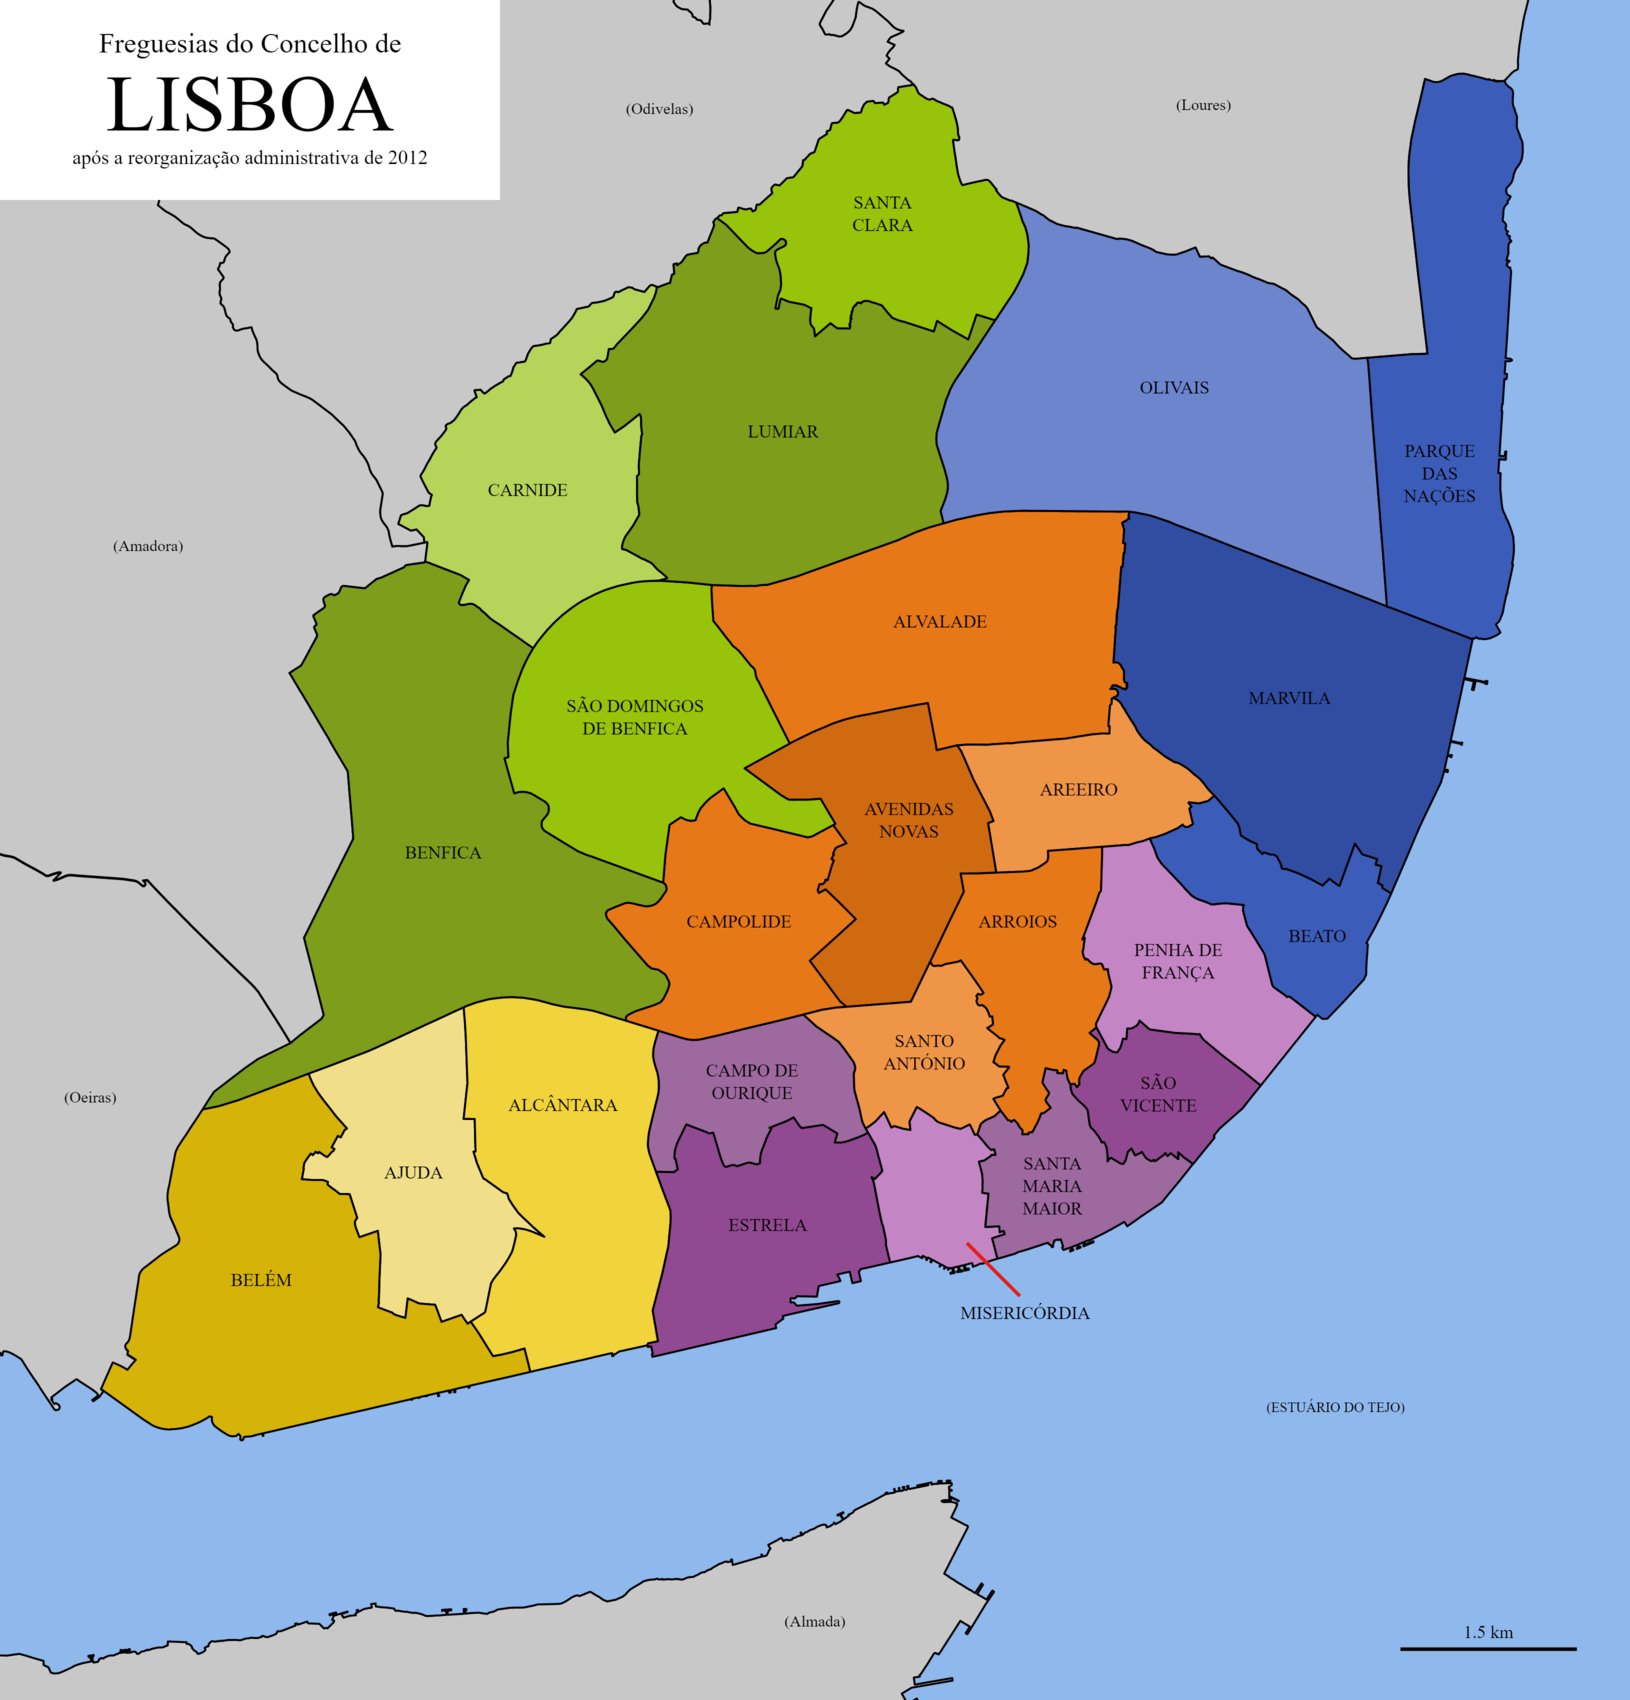

In [4]:
travel_lisbon_df = pd.DataFrame()
for tmp_con in travel_lisbon["features"]:
    origin_dicofre = tmp_con["properties"]["DicofreOR"]
    dest_dicofre = tmp_con["properties"]["DicofreDE"]
    travel_bike = tmp_con["properties"]["Bike"]
    travel_car = tmp_con["properties"]["Car"]
    travel_other = tmp_con["properties"]["Other"]
    travel_total = tmp_con["properties"]["Total"]
    
    tmp_travel_df = pd.DataFrame([[origin_dicofre, dest_dicofre, travel_bike, travel_car, travel_other, travel_total]], columns=["orig_dicofre", "dest_dicofre", "travel_bike", "travel_car", "travel_other", "travel_total"])
    travel_lisbon_df = pd.concat([travel_lisbon_df, tmp_travel_df])
travel_lisbon_df = travel_lisbon_df.reset_index(drop=True)

In [5]:
dicofre_translate.head()

,Dicofre,Freguesia,Concelho,Distrito,Area_T_ha,Area_EA_ha,Des_Simpli
0,081504,Sagres,Vila do Bispo,Faro,3436.91,0.04,Sagres
1,081504,Sagres,Vila do Bispo,Faro,3436.91,0.17,Sagres
2,081504,Sagres,Vila do Bispo,Faro,3436.91,0.20,Sagres
3,081504,Sagres,Vila do Bispo,Faro,3436.91,0.09,Sagres
4,081504,Sagres,Vila do Bispo,Faro,3436.91,0.39,Sagres


In [6]:
travel_lisbon_df = travel_lisbon_df.merge(dicofre_translate[["Dicofre", "Des_Simpli"]], left_on="orig_dicofre", right_on="Dicofre")
travel_lisbon_df = travel_lisbon_df.rename(columns={"Des_Simpli": "orig_name"})
travel_lisbon_df = travel_lisbon_df.merge(dicofre_translate[["Dicofre", "Des_Simpli"]], left_on="dest_dicofre", right_on="Dicofre")
travel_lisbon_df = travel_lisbon_df.rename(columns={"Des_Simpli": "dest_name"})
travel_lisbon_df = travel_lisbon_df.drop(["Dicofre_x", "Dicofre_y"], axis=1)

In [7]:
travel_lisbon_df

,orig_dicofre,dest_dicofre,travel_bike,travel_car,travel_other,travel_total,orig_name,dest_name
0,110601,110601,13.0,188.0,117.0,940.0,Ajuda,Ajuda
1,110602,110601,3.0,206.0,236.0,765.0,AlcÃ¢ntara,Ajuda
2,110607,110601,0.0,0.0,5.0,5.0,Beato,Ajuda
3,110608,110601,0.0,118.0,22.0,151.0,Benfica,Ajuda
4,110610,110601,0.0,53.0,62.0,115.0,Campolide,Ajuda
...,...,...,...,...,...,...,...,...
569,110663,110667,15.0,1639.0,72.0,2835.0,Penha de FranÃ§a,SÃ£o Vicente
570,110664,110667,0.0,0.0,18.0,30.0,Santa Clara,SÃ£o Vicente
571,110665,110667,0.0,414.0,849.0,1786.0,Santa Maria Maior,SÃ£o Vicente
572,110666,110667,0.0,83.0,60.0,161.0,Santo AntÃ³nio,SÃ£o Vicente


Check if cycling road passes by a given district by studying the polygon intersection and cycling road geometry

In [8]:
zone_cycling_road_df = pd.DataFrame()

for dist_idx in range(len(lisbon_geometry["features"])):
    tmp_dicofre = lisbon_geometry["features"][dist_idx]["properties"]["Dicofre"]
    tmp_name = lisbon_geometry["features"][dist_idx]["properties"]["DistrictName"]
    tmp_pop = lisbon_geometry["features"][dist_idx]["properties"]["Population2011"]
    tmp_lenght = 0
    counter = 0
    for idx in range(len(cycling_network["features"])):
        if(cycling_network["features"][idx]["geometry"]["type"] == "LineString"):
            intersect = LineString(cycling_network["features"][idx]["geometry"]["coordinates"]).intersects(Polygon(lisbon_geometry["features"][dist_idx]["geometry"]["coordinates"][0][0]))
        else:
            intersect = MultiLineString(cycling_network["features"][idx]["geometry"]["coordinates"]).intersects(Polygon(lisbon_geometry["features"][dist_idx]["geometry"]["coordinates"][0][0]))
        if(intersect):
            tmp_lenght += cycling_network["features"][idx]["properties"]["length"]
            counter += 1
    tmp_cycling_road_df = pd.DataFrame([[tmp_dicofre, tmp_name, tmp_pop, counter, tmp_lenght]], columns=["dicofre", "name", "population", "n_cycle_roads", "length_cycle_roads"])
    zone_cycling_road_df = pd.concat([zone_cycling_road_df, tmp_cycling_road_df])
zone_cycling_road_df = zone_cycling_road_df.reset_index(drop=True)
zone_cycling_road_df.sort_values(by="n_cycle_roads", ascending=False).head(20)

,dicofre,name,population,n_cycle_roads,length_cycle_roads
7,110621,MARVILA,37793.0,29,18889.095185
18,110662,PARQUE DAS NAÇÕES,21025.0,28,14661.707296
13,110657,AVENIDAS NOVAS,21625.0,25,16769.661358
10,110654,ALVALADE,31813.0,21,10873.177093
5,110611,CARNIDE,19218.0,19,15195.671119
8,110633,OLIVAIS,33788.0,18,10865.836202
6,110618,LUMIAR,45605.0,17,8356.881462
11,110655,AREEIRO,20131.0,11,3227.284182
3,110608,BENFICA,36985.0,11,17354.875059
9,110639,SÃO DOMINGOS DE BENFICA,33043.0,10,13341.463966


Overall we see that the districts with a bigger population tend to have a better cycling road network

In [9]:
common_cycling_road_df = pd.DataFrame()

for dist_idx_i in range(len(lisbon_geometry["features"])):
    tmp_dicofre_i = lisbon_geometry["features"][dist_idx_i]["properties"]["Dicofre"]
    tmp_name_i = lisbon_geometry["features"][dist_idx_i]["properties"]["DistrictName"]
    tmp_pop_i = lisbon_geometry["features"][dist_idx_i]["properties"]["Population2011"]
    
    for dist_idx_j in range(dist_idx_i+1, len(lisbon_geometry["features"])):
        tmp_dicofre_j = lisbon_geometry["features"][dist_idx_j]["properties"]["Dicofre"]
        tmp_name_j = lisbon_geometry["features"][dist_idx_j]["properties"]["DistrictName"]
        tmp_pop_j = lisbon_geometry["features"][dist_idx_j]["properties"]["Population2011"]
        
        if(tmp_dicofre_i==tmp_dicofre_j):
            continue
        counter = 0
        for idx in range(len(cycling_network["features"])):
            if(cycling_network["features"][idx]["geometry"]["type"] == "LineString"):
                intersect_1 = LineString(cycling_network["features"][idx]["geometry"]["coordinates"]).intersects(Polygon(lisbon_geometry["features"][dist_idx_i]["geometry"]["coordinates"][0][0]))
                intersect_2 = LineString(cycling_network["features"][idx]["geometry"]["coordinates"]).intersects(Polygon(lisbon_geometry["features"][dist_idx_j]["geometry"]["coordinates"][0][0]))
            else:
                intersect_1 = MultiLineString(cycling_network["features"][idx]["geometry"]["coordinates"]).intersects(Polygon(lisbon_geometry["features"][dist_idx_i]["geometry"]["coordinates"][0][0]))
                intersect_2 = MultiLineString(cycling_network["features"][idx]["geometry"]["coordinates"]).intersects(Polygon(lisbon_geometry["features"][dist_idx_i]["geometry"]["coordinates"][0][0]))
            
            intersect = intersect_1 & intersect_2
            if(intersect):
                counter += 1
        tmp_common_road_df = pd.DataFrame([[tmp_dicofre_i, tmp_name_i, tmp_pop_i, tmp_dicofre_j, tmp_name_j, tmp_pop_j, counter]], columns=["dicofre_1", "name_1", "population_1", "dicofre_2", "name_2", "population_2", "n_common_cycle_roads"])
        common_cycling_road_df = pd.concat([common_cycling_road_df, tmp_common_road_df])
common_cycling_road_df = common_cycling_road_df.reset_index(drop=True)
common_cycling_road_df.sort_values(by="n_common_cycle_roads", ascending=False).head(20)

,dicofre_1,name_1,population_1,dicofre_2,name_2,population_2,n_common_cycle_roads
94,110610,CAMPOLIDE,15460.0,110657,AVENIDAS NOVAS,21625.0,6
90,110610,CAMPOLIDE,15460.0,110639,SÃO DOMINGOS DE BENFICA,33043.0,5
174,110639,SÃO DOMINGOS DE BENFICA,33043.0,110657,AVENIDAS NOVAS,21625.0,4
105,110611,CARNIDE,19218.0,110618,LUMIAR,45605.0,4
67,110608,BENFICA,36985.0,110611,CARNIDE,19218.0,4
210,110656,ARROIOS,31653.0,110657,AVENIDAS NOVAS,21625.0,4
71,110608,BENFICA,36985.0,110639,SÃO DOMINGOS DE BENFICA,33043.0,3
171,110639,SÃO DOMINGOS DE BENFICA,33043.0,110654,ALVALADE,31813.0,2
136,110618,LUMIAR,45605.0,110664,SANTA CLARA,22480.0,2
187,110654,ALVALADE,31813.0,110657,AVENIDAS NOVAS,21625.0,2


For each pair of districts we studied the cycling road connectivity by analysing the number of cycling roads that connect the two. Several observations can be done by comparing this table with the one above:
- AVENIDAS NOVAS cycling network is really good, both for intra or inter region commuting. Connecting adjacent districts to this we can greatly increase the inter district reachibility of the network
- Despite the average number of intra district cycling roads, CAMPOLIDE is very well connected to the other districts
- On the other hand, MARVILA is the district with more cycling roads, but it has a poor inter-district connectivity (can be a good target for cycling road extension)
- CARNIDE, SÃO DOMINGOS DE BENFICA and BENFICA are well connected and seem to form a strongly connected region

## 2 - Check GIRA shared bike hotspots and cycling road presence

In [10]:
dicofre_translate = pd.read_csv(DATA_DIR+"dicofre_translation_table.csv")
with open(DATA_DIR+"LisbonCyclingNetwork.geojson", encoding="utf8") as f:
    cycling_network = geojson.load(f)

In [11]:
# clean dirty values
arr = []
for feature in cycling_network["features"]:
    if len(feature['geometry']['coordinates']) > 3:
        arr.append(feature)

#### See shared bike stations that are far from any cycling road

In [12]:
public_bike = pd.read_csv("../data/public_bike_spots.csv")

In [13]:
data=[
    go.Scattermapbox(
            lat=np.array(feature["geometry"]["coordinates"])[:, 1],
            lon=np.array(feature["geometry"]["coordinates"])[:, 0],
            mode="lines",
            line=dict(width=3, color='black')
        )
        for feature in arr
    ]

In [14]:
public_bike['coordinates'] = public_bike['position'].apply(lambda x: ast.literal_eval(x)['coordinates'])
coordinates = list(public_bike['coordinates'])

In [15]:
data2 =[go.Scattermapbox(
        lat=[str(coord[1])],
        lon=[str(coord[0])],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=8, color='red'
        ),
    )
       for coord in coordinates]

In [16]:
data = data + data2

### Lisbon cycling roads and GIRA bike stations

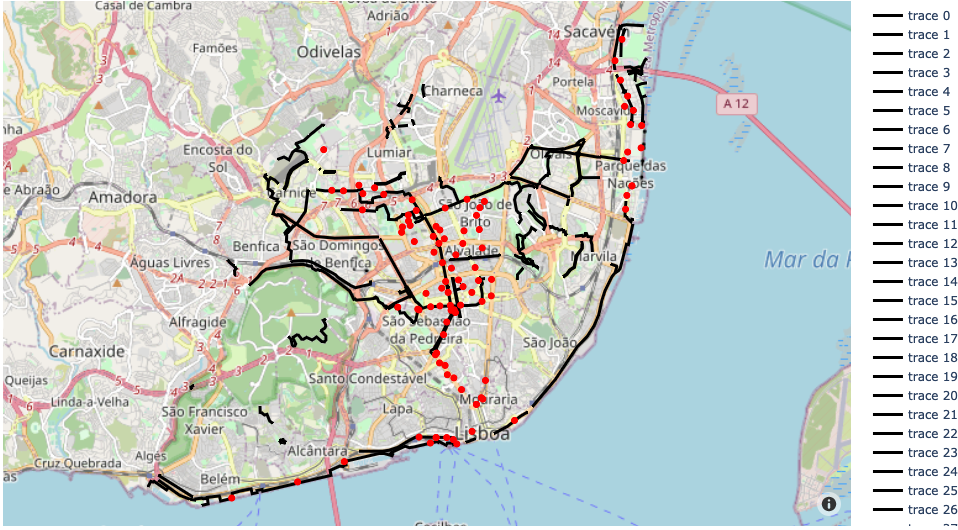

In [17]:
public_bike['tuple_coords'] = public_bike['coordinates'].apply(lambda x: (x[0],x[1]))

In [18]:
all_ciclabile_dict = dict()
for each in arr:
    name = each["properties"]["nome"]
    tuple_coords = [(x[0],x[1]) for x in each["geometry"]["coordinates"]]
    if name not in all_ciclabile_dict.keys():
        all_ciclabile_dict[name] = tuple_coords
    else:
        all_ciclabile_dict[name] = all_ciclabile_dict[name] + tuple_coords

In [19]:
def min_distance_from_ciclabile(spot):
    min_dist = 9999999
    closest_ciclabile = None
    for ciclabile in all_ciclabile_dict:
        for each in all_ciclabile_dict[ciclabile]:
            d = haversine(each, spot)
            if (d < min_dist):
                min_dist = d
                closest_ciclabile = ciclabile
    return closest_ciclabile,min_dist

In [20]:
public_bike['tuple_closest_ciclabile'] = public_bike['tuple_coords'].apply(lambda x : min_distance_from_ciclabile(x))
public_bike['closest_ciclabile'] = public_bike['tuple_closest_ciclabile'].apply(lambda x : x[0])
public_bike['dist_closest_ciclabile'] = public_bike['tuple_closest_ciclabile'].apply(lambda x : x[1])

In [21]:
# Here we have for each bike sharing spot its own distance to the closest bike lane
public_bike[["desigcomercial","closest_ciclabile","dist_closest_ciclabile"]].sort_values(by = "dist_closest_ciclabile", ascending=False)

,desigcomercial,closest_ciclabile,dist_closest_ciclabile
49,309 - Rua da Palma,Av. Infante Dom Henrique,1.277863
62,301 - Avenida da Liberdade / Restauradores,Marquês de Pombal,1.146955
3,225 - Martim Moniz,Av. Infante Dom Henrique,0.940073
80,224 - Martim Moniz,Av. Infante Dom Henrique,0.892786
69,222 - Praça da Figueira,Av. Ribeira das Naus,0.817157
...,...,...,...
39,307 - Marquês de Pombal,Marquês de Pombal,0.008750
90,420 - Av. Rovisco Pais / Av. Manuel da Maia,Av. Manuel da Maia,0.007440
31,308 - Marquês de Pombal,Marquês de Pombal,0.007440
95,485 - Rua Tomás da Fonseca / Rua António Albin...,Rua Tomás da Fonseca,0.005600


From the map and table above we can highlight a set of zones where the cycling roads should be extended:

- **São João de Brito/Alvalade:** in this zone there is a clear block with several bike stations and no cycling roads. A cycling road on a main and large street of the neighbourhood (passing by one or two stations) should be enough to solve this, as there are several cycling roads around.
- **Parque das Nações:** there is a zone with GIRA bike stations between two cycling roads that are not connected. We suggest to connect these two, to both create a new extended road and provide cycling road access to these stations.
- **Mouraria (and Alfama):** this is one of the oldest zones of the city, with several narrow streets on the top of a hill. For this reason we consider that it can be unpractical to extend the network in this zone. However there are GIRA stations there, and with the rise of electrical bikes the steepness issue is overcome. Thanks to this our suggestion is to speak with the local community to understand what can be done.

### Find the cycling roads that are close together and are not connected
The easiest way to fill in the gaps is to see which cycling roads are already very close together. In this way the objective could be achieved in a cheap way (although it needs to be complemented by the other analysis we made so that it's done in an informed way)

In [22]:
def min_distance_between_two_ciclabili(c1, c2):
    min_dist = 9999999
    
    coords1 = all_ciclabile_dict[c1]
    coords2 = all_ciclabile_dict[c2]
    
    for coord1 in coords1:
        for coord2 in coords2:
            d = haversine(coord1, coord2)
            if (d < min_dist):
                min_dist = d
    return min_dist

In [23]:
min_distance_between_two_ciclabili('Radial de Benfica - Campolide - Pq. Ed. VII', 'Gulbenkian')

0.11425880426185354

In [24]:
all_ciclabili = list(all_ciclabile_dict.keys())

In [25]:
df_ciclabili = pd.DataFrame()
for a, b in itertools.combinations(all_ciclabili,2):
    d = min_distance_between_two_ciclabili(a,b)
    df2 = pd.DataFrame([[a,b,d]], columns=['ciclabile1', 'ciclabile2', 'dist'])
    df_ciclabili = pd.concat([df_ciclabili, df2])

In [26]:
# here we have the distance we have between the two closest points of each bike lane
pd.set_option('display.max_rows', 5000)
df_ciclabili.loc[df_ciclabili['dist']>0].sort_values(by='dist')

,ciclabile1,ciclabile2,dist
0,Benfica-Pontinha,Estrada da Pontinha,0.001098
0,Av. Calouste Gulbenkien,Ligação da Av. Calouste Gulbekian à Ponte Gonç...,0.001098
0,Rotunda Visconde de Alvalade,R. Professor Fernando da Fonseca,0.001098
0,Av. da República,Cruzamento Av. da Républica x Av. Elias Garcia,0.001098
0,Av. Manuel da Maia,Praça de Londres,0.001098
...,...,...,...
0,Caminho dos Rouxinóis,Doca Pesca,17.430357
0,Pq. Nações - Junto ao Rio Trancão,Av. Brasília (Algés - Belém),17.457742
0,Caminho dos Pardais,Doca Pesca,17.460520
0,Doca Pesca,Rotunda Via do Oriente,17.733012


From the table above we can see which are the cycling road points that are close together but on different cycling roads, and so strong candidate places to join the two.

## 3 - District centroid analysis
In this analysis we intend to figure out locations where there is a lack of bike lanes close to district centroids. We handled data from 24 Lisbon districts provided with 3502 bike lanes. In addition, we analysed the mobility pattern of each district to find relevant discrepancies.

In [27]:
cycling_network.keys()

dict_keys(['type', 'name', 'crs', 'features'])

In [28]:
len(cycling_network['features'])

186

In [29]:
all_coordinates_cycling_network = list()

for each_trace in cycling_network['features']:
    for each_spot in each_trace['geometry']['coordinates']:
        if len(each_spot) != 2:
            for each_each in each_spot:
                if len(each_each) == 2:
                    all_coordinates_cycling_network.append(each_each)
        else:
            all_coordinates_cycling_network.append(each_spot)

In [30]:
len(all_coordinates_cycling_network)

3502

In [31]:
with open(DATA_DIR+"TravelSurveyLisbon.geojson", encoding="utf8") as f:
    travel_survey_lisbon = geojson.load(f)

In [32]:
all_points_interest = list()

for each_trace in travel_survey_lisbon['features']:
    for each_spot in each_trace['geometry']['coordinates']:
        if each_spot not in all_points_interest:
            all_points_interest.append(each_spot)

#### Compute distances
Compute the distance between each district centroid and all bike lanes to obtain the closest cycling road.

In [33]:
all_haversine_distance = dict()

for each_one_point in all_points_interest:
    for each_distance in all_coordinates_cycling_network:
        all_haversine_distance.setdefault(str(each_one_point), dict())
        try:
            all_haversine_distance[str(each_one_point)][str(each_distance)] = haversine(tuple(each_one_point), tuple(each_distance), unit='km')
        except:
            pass

In [34]:
all_data = list()


for each_point in all_haversine_distance:
    
    coordinates = [float(each_point.split(",")[0].split("[")[1]), float(each_point.split(",")[1].split("]")[0])]
    
    min_key = min(all_haversine_distance[each_point], key=lambda k: all_haversine_distance[each_point][k])
    max_key = max(all_haversine_distance[each_point], key=lambda k: all_haversine_distance[each_point][k])
    min_value = all_haversine_distance[each_point][min_key]
    max_value = all_haversine_distance[each_point][max_key]
    avg_value = mean(all_haversine_distance[each_point].values())
    
    amount_bike = 0
    amount_car = 0
    amount_other = 0
    amount_total = 0
    amount_walk = 0

    lat_closest = float(min_key.split(",")[1].split("]")[0])
    long_closest = float(min_key.split(",")[0].split("[")[1])
    
    lat_origin = float(each_point.split(",")[1].split("]")[0])
    long_origin = float(each_point.split(",")[0].split("[")[1])
    
    coordinates = [float(each_point.split(",")[0].split("[")[1]), float(each_point.split(",")[1].split("]")[0])]
    
    for each_iter in travel_survey_lisbon['features']:
        if coordinates in each_iter['geometry']['coordinates']:
            amount_car += each_iter['properties']['Car']
            amount_bike += each_iter['properties']['Bike']
            amount_other += each_iter['properties']['Other']
            amount_total += each_iter['properties']['Total']
            amount_walk += each_iter['properties']['Walk']
    
    all_data.append(
        [
            lat_origin, long_origin, lat_closest, long_closest, 
            float(min_value), max_key, float(max_value), float(avg_value), 
            amount_car, amount_bike, amount_other, 
            amount_total, amount_walk
        ]
    )

In [35]:
df_distances = pd.DataFrame(
    data=np.array(all_data).reshape((-1, 13)), 
    columns=[
        "Lat_centroid", "Long_centroid", "Lat_closest_bikelane", "Long_closest_bikelane",
        "Closest_dist", "Farthest_bikelane", "Farthest_dist", "Avg_dist", 
        "Amount_car", "Amount_bike", "Amount_other",
        "Amount_total", "Amount_walk"
    ]
)

df_distances['Closest_dist'] = df_distances['Closest_dist'].astype(float)
df_distances['Farthest_dist'] = df_distances['Farthest_dist'].astype(float) 
df_distances['Avg_dist'] = df_distances['Avg_dist'].astype(float) 
df_distances['Amount_total'] = df_distances['Amount_total'].astype(float)
df_distances['Amount_car'] = df_distances['Amount_car'].astype(float) 
df_distances['Amount_bike'] = df_distances['Amount_bike'].astype(float)
df_distances['Amount_walk'] = df_distances['Amount_walk'].astype(float)

df_distances['Car_ratio'] = df_distances['Amount_car'] / df_distances['Amount_total']

In [36]:
df_distances['Closest_dist'] = df_distances['Closest_dist'].astype(float)
df_distances['Farthest_dist'] = df_distances['Farthest_dist'].astype(float) 
df_distances['Avg_dist'] = df_distances['Avg_dist'].astype(float) 
df_distances['Amount_total'] = df_distances['Amount_total'].astype(float)
df_distances['Amount_car'] = df_distances['Amount_car'].astype(float) 
df_distances['Amount_bike'] = df_distances['Amount_bike'].astype(float)
df_distances['Amount_walk'] = df_distances['Amount_walk'].astype(float)

In [37]:
df_distances['Car_ratio'] = df_distances['Amount_car'] / df_distances['Amount_total']
df_distances['Walk_ratio'] = df_distances['Amount_walk'] / df_distances['Amount_total']
df_distances['Bike_ratio'] = df_distances['Amount_bike'] / df_distances['Amount_total']

In [38]:
sum(list(df_distances['Car_ratio'])) / len(df_distances)

0.40919425136757176

In [39]:
sum(list(df_distances['Walk_ratio'])) / len(df_distances)

0.2878336416633431

In [40]:
sum(list(df_distances['Bike_ratio'])) / len(df_distances)

0.005607115833034925

In [41]:
df_distances.head()

,Lat_centroid,Long_centroid,Lat_closest_bikelane,Long_closest_bikelane,Closest_dist,Farthest_bikelane,Farthest_dist,Avg_dist,Amount_car,Amount_bike,Amount_other,Amount_total,Amount_walk,Car_ratio,Walk_ratio,Bike_ratio
0,38.707895,-9.197001,38.71002,-9.19561,0.279875,"[-9.09174, 38.79593]",15.178962,7.532798,5719.0,87.0,5435.0,15353.0,4116.0,0.372500,0.268091,0.005667
1,38.706978,-9.182567,38.69949,-9.17897,0.914110,"[-9.09174, 38.79593]",14.048684,6.752091,14948.0,275.0,12733.0,41727.0,13769.0,0.358233,0.329978,0.006590
2,38.734714,-9.117262,38.74141,-9.11413,0.813477,"[-9.229656, 38.695873]",13.204944,5.308044,10366.0,0.0,10076.0,28474.0,8039.0,0.364051,0.282328,0.000000
3,38.747338,-9.20064,38.74279,-9.19757,0.604768,"[-9.09174, 38.79593]",13.232090,6.383570,31584.0,82.0,17530.0,75497.0,26307.0,0.418348,0.348451,0.001086
4,38.72954,-9.166772,38.73119,-9.16789,0.219686,"[-9.09174, 38.79593]",11.078555,4.628547,26846.0,249.0,20868.0,68305.0,20343.0,0.393031,0.297826,0.003645


In [42]:
max_total = max(df_distances['Amount_total'])
df_distances[df_distances['Amount_total'] == max_total][['Lat_centroid', 'Long_centroid', 'Lat_closest_bikelane', 'Long_closest_bikelane', 'Closest_dist', 'Amount_total', 'Car_ratio', 'Walk_ratio', 'Bike_ratio']]

,Lat_centroid,Long_centroid,Lat_closest_bikelane,Long_closest_bikelane,Closest_dist,Amount_total,Car_ratio,Walk_ratio,Bike_ratio
13,38.740238,-9.153009,38.7379,-9.15641,0.457047,136834.0,0.367284,0.322157,0.00513


The district with higher flux is Avenidas Novas with 136834 total trips registered. In addition, the district with a higher ratio of trips using bikes is Parque das Nações (below). 

In [43]:
max_total = max(df_distances['Bike_ratio'])
df_distances[df_distances['Bike_ratio'] == max_total][['Lat_centroid', 'Long_centroid', 'Lat_closest_bikelane', 'Long_closest_bikelane', 'Closest_dist', 'Amount_total', 'Car_ratio', 'Walk_ratio', 'Bike_ratio']]

,Lat_centroid,Long_centroid,Lat_closest_bikelane,Long_closest_bikelane,Closest_dist,Amount_total,Car_ratio,Walk_ratio,Bike_ratio
18,38.777516,-9.098468,38.77916,-9.09557,0.369355,55868.0,0.533973,0.122736,0.022929


In [44]:
df_plot = df_distances[df_distances['Closest_dist'] > 0.7]
mean_value = sum(list(df_distances['Car_ratio'])) / len(df_distances)

df_plot = df_plot[df_plot['Car_ratio'] < mean_value][['Lat_centroid', 'Long_centroid', 'Lat_closest_bikelane', 'Long_closest_bikelane', 'Closest_dist', 'Amount_total', 'Car_ratio', 'Walk_ratio', 'Bike_ratio']]
df_plot

,Lat_centroid,Long_centroid,Lat_closest_bikelane,Long_closest_bikelane,Closest_dist,Amount_total,Car_ratio,Walk_ratio,Bike_ratio
1,38.706978,-9.182567,38.69949,-9.17897,0.914110,41727.0,0.358233,0.329978,0.006590
2,38.734714,-9.117262,38.74141,-9.11413,0.813477,28474.0,0.364051,0.282328,0.000000
12,38.727268,-9.136561,38.73345,-9.13424,0.726103,96535.0,0.280396,0.423432,0.005242
15,38.717829,-9.165163,38.72464,-9.17192,1.059970,43133.0,0.271973,0.511001,0.000927
19,38.728644,-9.125841,38.73345,-9.13424,1.072668,65468.0,0.350141,0.337631,0.001589


Based on our mobility analysis we can highlight five districts with a low ratio of trips using cars and  no bike lanes near its centroids. Consequently, we stress a lack of bike lanes in those districts: Alcântara, Campo de Ourique, Marvila, Arroios, Estrela.

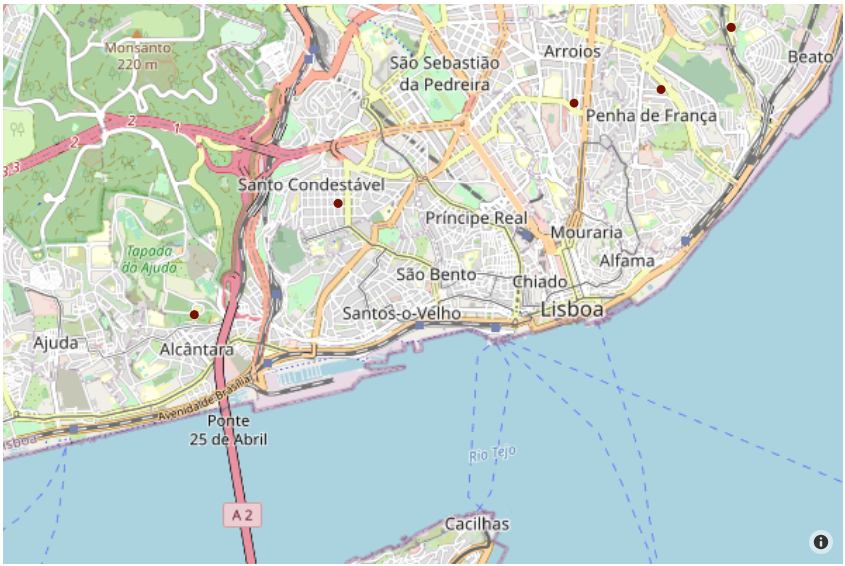

To conclude this analyse, we plot the whole cycling network of Lisbon and the districts with the closest bike lines at least 700 meters.

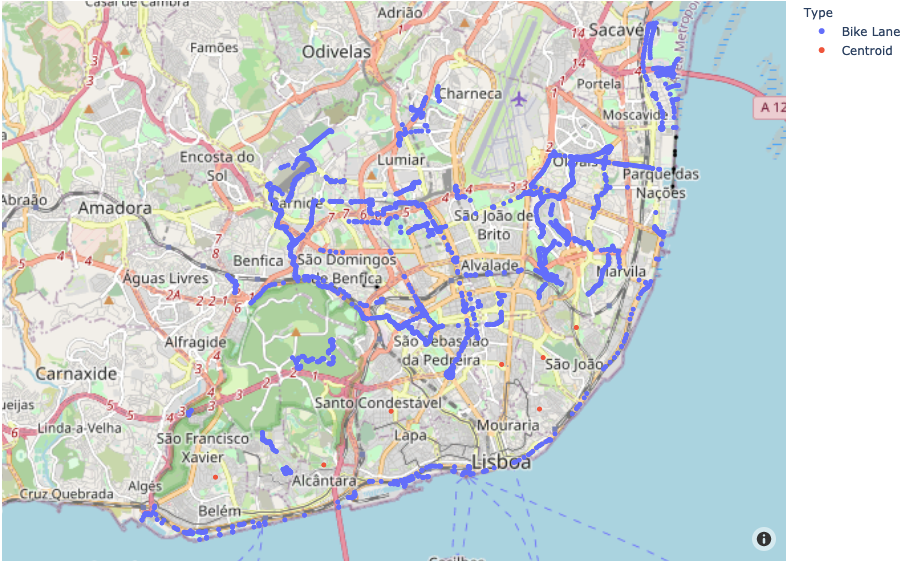

## 4 - Graph analysis
### Build the graph

In [47]:
with open(DATA_DIR+"LisbonCyclingNetwork.geojson", encoding="utf8") as f:
    cycling_network = geojson.load(f)['features']
    
with open(DATA_DIR+"LisbonDistricts_Geom_Population.geojson", encoding="utf8") as f:
    districts_geom = geojson.load(f)['features']

In [48]:
print('Number of tracks:', len(cycling_network))
print('Number of locations:', len(districts_geom))

Number of tracks: 186
Number of locations: 24


In [49]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

tracks_trajectory = {}
for track in cycling_network:
    trajetory = []
    track_coordinates = track['geometry']['coordinates'] if track['geometry']['type'] == 'LineString' else \
                        sum(track['geometry']['coordinates'], [])
    for coords in track_coordinates:
        point = Point(coords[0], coords[1])
        for location in districts_geom:
            poly = Polygon(location['geometry']['coordinates'][0][0])
            if poly.contains(point):
                trajetory.append(location['properties']['Dicofre'])
    tracks_trajectory[track['properties']['id']] = list(dict.fromkeys(trajetory))

In [50]:
# ignore tracks that only pass by one District
tracks_trajectory = {k: v for k, v in tracks_trajectory.items() if len(v) > 1}
tracks_trajectory

{'1': ['110608', '110639', '110610', '110657'],
 '4': ['110610', '110657'],
 '10': ['110611', '110618'],
 '11': ['110611', '110608'],
 '46': ['110654', '110618'],
 '47': ['110618', '110611'],
 '52': ['110611', '110608'],
 '58': ['110657', '110655'],
 '66': ['110654', '110618'],
 '100': ['110611', '110608'],
 '106': ['110658', '110602', '110660', '110661'],
 '107': ['110621', '110607', '110663', '110667'],
 '108': ['110654', '110639'],
 '520': ['110621', '110662'],
 '811': ['110658', '110608'],
 '819': ['110657', '110656'],
 '825': ['110661', '110660'],
 '874': ['110657', '110666'],
 '876': ['110654', '110657'],
 '879': ['110666', '110656'],
 '1013': ['110657', '110655'],
 '1071': ['110618', '110664'],
 '1237': ['110618', '110664'],
 '1391': ['110618', '110611'],
 '1623': ['110656', '110657'],
 '1639': ['110656', '110657'],
 '1640': ['110657', '110656'],
 '1660': ['110655', '110656'],
 '1681': ['110621', '110633', '110662'],
 '1758': ['110657', '110610'],
 '1868': ['110621', '110654'],


In [51]:
# get adjacent districts
districts_adjencies = dict.fromkeys(sum(tracks_trajectory.values(), []))
for d in districts_adjencies:
    adjencies = []
    for track in tracks_trajectory:
        tracks_trajet = tracks_trajectory[track]
        if d in tracks_trajet:
            index = tracks_trajet.index(d)
            if index > 0:
                adjencies.append(tracks_trajet[index-1])
            if index < len(tracks_trajet) - 1:
                adjencies.append(tracks_trajet[index+1])
    districts_adjencies[d] = list(set(adjencies))

In [52]:
districts_adjencies

{'110608': ['110611', '110639', '110658'],
 '110639': ['110610', '110654', '110611', '110657', '110608'],
 '110610': ['110657', '110639'],
 '110657': ['110666', '110610', '110654', '110655', '110656', '110639'],
 '110611': ['110618', '110639', '110608'],
 '110618': ['110611', '110664', '110654'],
 '110654': ['110618', '110639', '110621', '110657'],
 '110655': ['110656', '110657'],
 '110658': ['110608', '110602'],
 '110602': ['110660', '110658'],
 '110660': ['110602', '110661'],
 '110661': ['110660'],
 '110621': ['110607', '110633', '110654', '110662'],
 '110607': ['110663', '110621'],
 '110663': ['110607', '110667'],
 '110667': ['110663'],
 '110662': ['110633', '110621'],
 '110656': ['110655', '110657', '110665', '110666'],
 '110666': ['110656', '110657'],
 '110664': ['110618'],
 '110633': ['110621', '110662'],
 '110665': ['110656']}

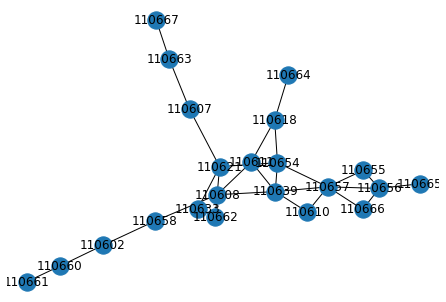

In [53]:
G = nx.Graph(districts_adjencies)
nx.draw(G, with_labels = True)

In [54]:
df_travel_routes = geopandas.read_file(DATA_DIR+"TravelSurveyLisbon.geojson")
df_travel_routes = df_travel_routes.drop('geometry', axis=1)

In [55]:
df_travel_routes_sorted = df_travel_routes.sort_values(['Total', 'Bike'], ascending=[False, True])

In [56]:
df_travel_routes_sorted.head(10)

,DicofreOR,DicofreDE,Car,Bike,Walk,Other,Total
75,110608,110608,7910.0,0.0,17666.0,3164.0,28740.0
300,110656,110656,1848.0,109.0,19398.0,4872.0,26226.0
175,110621,110621,6963.0,0.0,13995.0,2335.0,23294.0
200,110633,110633,4790.0,142.0,13663.0,3199.0,21794.0
150,110618,110618,6924.0,84.0,11398.0,2285.0,20691.0
250,110654,110654,4819.0,34.0,13694.0,1986.0,20533.0
325,110657,110657,4627.0,26.0,11266.0,2725.0,18643.0
375,110659,110659,1276.0,0.0,11807.0,1408.0,14491.0
225,110639,110639,2858.0,0.0,9364.0,1510.0,13733.0
475,110663,110663,3268.0,0.0,7894.0,2543.0,13705.0


In [57]:
df_travel_routes_inter_dist = df_travel_routes_sorted[df_travel_routes_sorted['DicofreOR'] != df_travel_routes_sorted['DicofreDE']].copy()

In [58]:
df_travel_routes_inter_dist.head(10)

,DicofreOR,DicofreDE,Car,Bike,Walk,Other,Total
349,110658,110657,4273.0,0.0,3108.0,467.0,7849.0
326,110657,110658,4086.0,0.0,2983.0,760.0,7830.0
154,110618,110654,4115.0,335.0,384.0,1860.0,6694.0
246,110654,110618,2988.0,314.0,564.0,2743.0,6609.0
301,110656,110657,1181.0,36.0,3476.0,1384.0,6078.0
324,110657,110656,1305.0,49.0,3122.0,1281.0,5756.0
318,110657,110618,3873.0,0.0,230.0,1607.0,5710.0
157,110618,110657,3225.0,0.0,138.0,1842.0,5205.0
253,110654,110657,2381.0,47.0,1409.0,1303.0,5140.0
530,110666,110610,969.0,0.0,2722.0,1381.0,5072.0


In [59]:
def get_path(row):
    if not row['DicofreOR'] in G.nodes or not row['DicofreDE'] in G.nodes:
        return []
    else:
        return nx.bidirectional_shortest_path(G, row['DicofreOR'], row['DicofreDE'])
    
df_travel_routes_inter_dist['Path'] = df_travel_routes_inter_dist.apply(get_path, axis=1)

In [60]:
# Paths between two districts
df_travel_routes_inter_dist[['DicofreOR', 'DicofreDE', 'Path']].head(10)

,DicofreOR,DicofreDE,Path
349,110658,110657,"[110658, 110608, 110639, 110657]"
326,110657,110658,"[110657, 110639, 110608, 110658]"
154,110618,110654,"[110618, 110654]"
246,110654,110618,"[110654, 110618]"
301,110656,110657,"[110656, 110657]"
324,110657,110656,"[110657, 110656]"
318,110657,110618,"[110657, 110654, 110618]"
157,110618,110657,"[110618, 110654, 110657]"
253,110654,110657,"[110654, 110657]"
530,110666,110610,"[110666, 110657, 110610]"


### Graph analysis

In [61]:
df_cycling_paths = pd.read_csv(DATA_DIR+'cycling_paths_per_route.csv', converters={'Path': eval})
df_cycling_paths['DicofreOR'] = df_cycling_paths['DicofreOR'].astype(int)
df_cycling_paths['DicofreDE'] = df_cycling_paths['DicofreDE'].astype(int)

In [62]:
df_travel_routes['DicofreOR'] = df_travel_routes['DicofreOR'].astype(int)
df_travel_routes['DicofreDE'] = df_travel_routes['DicofreDE'].astype(int)

In [63]:
df_district_info = geopandas.read_file(DATA_DIR+"LisbonDistricts_Geom_Population.geojson")
df_district_info = df_district_info.drop(['geometry', 'Population2011'] , axis=1)
df_district_info['Dicofre'] = df_district_info['Dicofre'].astype(int)

In [64]:
df_district_info.head()

,Dicofre,DistrictName
0,110601,AJUDA
1,110602,ALCÂNTARA
2,110607,BEATO
3,110608,BENFICA
4,110610,CAMPOLIDE


In [65]:
df_merged = pd.merge(df_travel_routes, df_cycling_paths, how='left', left_on=['DicofreOR','DicofreDE'], right_on = ['DicofreOR','DicofreDE'])

# Merge DicofreOR district name
df_merged = pd.merge(df_merged, df_district_info, how='left', left_on='DicofreOR', right_on = 'Dicofre')
df_merged = df_merged.rename(columns={'DistrictName': 'DistrictNameOR'})
df_merged = df_merged.drop('Dicofre', axis=1)

# Merge DicofreDE district name
df_merged = pd.merge(df_merged, df_district_info, how='right', left_on='DicofreDE', right_on = 'Dicofre')
df_merged = df_merged.rename(columns={'DistrictName': 'DistrictNameDE'})
df_merged = df_merged.drop('Dicofre', axis=1)

#Drop routes where DicofreOR == DicofreDE
df_merged = df_merged[df_merged['DicofreOR'] != df_merged['DicofreDE']]
df_merged = df_merged[['DicofreOR', 'DicofreDE', 'DistrictNameOR','DistrictNameDE','Car','Bike','Walk','Other','Total','Path']]

In [66]:
df_no_cycling_path = df_merged[df_merged['Path'].str.len() == 0]

In [67]:
df_no_cycling_path.head()

,DicofreOR,DicofreDE,DistrictNameOR,DistrictNameDE,Car,Bike,Walk,Other,Total,Path
1,110602,110601,ALCÂNTARA,AJUDA,206.0,3.0,320.0,236.0,765.0,[]
2,110607,110601,BEATO,AJUDA,0.0,0.0,0.0,5.0,5.0,[]
3,110608,110601,BENFICA,AJUDA,118.0,0.0,11.0,22.0,151.0,[]
4,110610,110601,CAMPOLIDE,AJUDA,53.0,0.0,0.0,62.0,115.0,[]
5,110611,110601,CARNIDE,AJUDA,27.0,0.0,0.0,10.0,38.0,[]


In [68]:
df_no_cycling_path['DistrictNameOR'].value_counts()

CAMPO DE OURIQUE           23
AJUDA                      23
ALCÂNTARA                   2
MARVILA                     2
OLIVAIS                     2
SÃO VICENTE                 2
LUMIAR                      2
AREEIRO                     2
SANTA MARIA MAIOR           2
BEATO                       2
AVENIDAS NOVAS              2
ESTRELA                     2
ARROIOS                     2
SANTO ANTÓNIO               2
PARQUE DAS NAÇÕES           2
SANTA CLARA                 2
BENFICA                     2
MISERICÓRDIA                2
ALVALADE                    2
CAMPOLIDE                   2
PENHA DE FRANÇA             2
CARNIDE                     2
BELÉM                       2
SÃO DOMINGOS DE BENFICA     2
Name: DistrictNameOR, dtype: int64

AJUDA and CAMPO DE OURIQUE have no possible bike paths to any of the other districts, since all the inter districts travelling routes origining from those two districts have an empty path in the cycling graph. 

For the other districts, only two routes are not feasible through the cycling network. These correspond to trips to either AJUDA or CAMPO DE OURIQUE as it can be seen below.

So a first step would be to build a cycling road that connects  AJUDA and CAMPO DE OURIQUE to one of the other districts, ideally to the closest one, in order to fully connect the 24 districts in the cycling network.
- For AJUDA the best way would be to connect it to ALCANTARA or BELEM
- For CAMPO DE OURIQUE the best way would be to connect it CAMPOLIDE, bringing it closer to the rich network of AVENIDAS NOVAS

In [69]:
df_no_cycling_path[~ df_no_cycling_path['DistrictNameOR'].isin(['AJUDA', 'CAMPO DE OURIQUE'])].sort_values('DistrictNameOR').head(20)

,DicofreOR,DicofreDE,DistrictNameOR,DistrictNameDE,Car,Bike,Walk,Other,Total,Path
1,110602,110601,ALCÂNTARA,AJUDA,206.0,3.0,320.0,236.0,765.0,[]
359,110602,110659,ALCÂNTARA,CAMPO DE OURIQUE,413.0,0.0,52.0,159.0,625.0,[]
368,110654,110659,ALVALADE,CAMPO DE OURIQUE,103.0,0.0,10.0,133.0,246.0,[]
10,110654,110601,ALVALADE,AJUDA,57.0,0.0,0.0,30.0,87.0,[]
369,110655,110659,AREEIRO,CAMPO DE OURIQUE,167.0,0.0,0.0,137.0,304.0,[]
11,110655,110601,AREEIRO,AJUDA,299.0,3.0,0.0,35.0,337.0,[]
370,110656,110659,ARROIOS,CAMPO DE OURIQUE,216.0,0.0,404.0,505.0,1125.0,[]
12,110656,110601,ARROIOS,AJUDA,20.0,0.0,2.0,22.0,44.0,[]
371,110657,110659,AVENIDAS NOVAS,CAMPO DE OURIQUE,327.0,0.0,38.0,182.0,547.0,[]
13,110657,110601,AVENIDAS NOVAS,AJUDA,948.0,3.0,1142.0,1596.0,3689.0,[]


In [70]:
import json
with open(DATA_DIR+'freguesias.json', 'r', encoding='utf-8') as f:
    adjancencies = json.load(f)

In [71]:
df_adj_dist_cycling_path = df_merged.drop(['Car', 'Walk', 'Other'], axis=1)
def are_adjacent(row):
    return row['DistrictNameDE'] in adjancencies[row['DistrictNameOR']]
        
df_adj_dist_cycling_path['are_adjacent?'] = df_adj_dist_cycling_path.apply(are_adjacent, axis=1)
df_adj_dist_cycling_path = df_adj_dist_cycling_path[df_adj_dist_cycling_path['are_adjacent?'] == True]

In [75]:
df_adj_dist_cycling_path.head(10)

,DicofreOR,DicofreDE,DistrictNameOR,DistrictNameDE,Bike,Total,Path,are_adjacent?,#_districts_in_between
1,110602,110601,ALCÂNTARA,AJUDA,3.0,765.0,[],True,-2
3,110608,110601,BENFICA,AJUDA,0.0,151.0,[],True,-2
14,110658,110601,BELÉM,AJUDA,0.0,494.0,[],True,-2
24,110601,110602,AJUDA,ALCÂNTARA,3.0,811.0,[],True,-2
27,110608,110602,BENFICA,ALCÂNTARA,0.0,405.0,"[110608, 110658, 110602]",True,1
38,110658,110602,BELÉM,ALCÂNTARA,3.0,1340.0,"[110658, 110602]",True,0
39,110659,110602,CAMPO DE OURIQUE,ALCÂNTARA,0.0,306.0,[],True,-2
40,110660,110602,ESTRELA,ALCÂNTARA,0.0,1870.0,"[110660, 110602]",True,0
55,110621,110607,MARVILA,BEATO,0.0,2598.0,"[110621, 110607]",True,0
59,110655,110607,AREEIRO,BEATO,0.0,2790.0,"[110655, 110657, 110654, 110621, 110607]",True,3


In [73]:
df_adj_dist_cycling_path['#_districts_in_between'] = df_adj_dist_cycling_path['Path'].str.len() - 2
df_adj_dist_cycling_path_filtered = df_adj_dist_cycling_path[df_adj_dist_cycling_path['#_districts_in_between'] > 0]

In [74]:
df_adj_dist_cycling_path_filtered.sort_values(['Total', '#_districts_in_between'], ascending=False).head(20)

,DicofreOR,DicofreDE,DistrictNameOR,DistrictNameDE,Bike,Total,Path,are_adjacent?,#_districts_in_between
117,110666,110610,SANTO ANTÓNIO,CAMPOLIDE,0.0,5072.0,"[110666, 110657, 110610]",True,1
306,110663,110656,PENHA DE FRANÇA,ARROIOS,0.0,3841.0,"[110663, 110607, 110621, 110654, 110657, 110656]",True,4
221,110618,110639,LUMIAR,SÃO DOMINGOS DE BENFICA,21.0,3537.0,"[110618, 110654, 110639]",True,1
466,110656,110663,ARROIOS,PENHA DE FRANÇA,0.0,3150.0,"[110656, 110657, 110654, 110621, 110607, 110663]",True,4
201,110654,110633,ALVALADE,OLIVAIS,24.0,3074.0,"[110654, 110621, 110633]",True,1
465,110655,110663,AREEIRO,PENHA DE FRANÇA,0.0,3004.0,"[110655, 110657, 110654, 110621, 110607, 110663]",True,4
152,110639,110618,SÃO DOMINGOS DE BENFICA,LUMIAR,0.0,2927.0,"[110639, 110611, 110618]",True,1
250,110655,110654,AREEIRO,ALVALADE,128.0,2800.0,"[110655, 110657, 110654]",True,1
59,110655,110607,AREEIRO,BEATO,0.0,2790.0,"[110655, 110657, 110654, 110621, 110607]",True,3
265,110607,110655,BEATO,AREEIRO,0.0,2732.0,"[110607, 110621, 110654, 110657, 110655]",True,3


On the table above we can see the adjacent districts that force us to cross up to 7 districts to go from one another. These should be the focus of our analysis, and together with the local communities we should understand the best way to extend these to make the inter-district travelling more direct.

## Conclusions

### Scalability and Impact
Our solution is designed to be implemented in a city since the starting point of our analysis was the cycling network already existing in Lisbon. There are different objectives to pursue when an extension of the existing cycling roads is planned. 

The first approach and also the most straightforward one is to see the closest cycling roads in order to literally 'fill the gap' between two different paths and generate in this way a bigger one. Unfortunately there can be some feasability problem that from our data we couldn't get and for this reason a human review (possibly of a local) is necessary. 
The second approach we followed was more socially oriented since we tried to highlight the bike sharing spots which are far from any bike roads and that are potentially unpractical for people renting a bike. In our opinion it is really important that all of those are served by a cycling road (at least shared) in order to let people feel more confortable in riding a bike and so more willing to use bikes. 
Although we targeted GIRA stations, a similar analysis can be done to any interesting "hotspots", for example:
- To extend it thinking about tourism, these hotspots can be statues, churches, museums, ..., that are the most visited places of the city
- To extend it thinking about locals, these hotspots can be big office areas, local supermarkets, coffee places, etc

Finally, since we had data concerning the demographics of each district (its centroid), we focused a part of our work on that analysis. This is once more focused on locals that can either have their bike or use a shared one, generally to commute on a daily basis. Focusing our analysis on this region is good since it is the most dense one, and so by solving a problem here we will solve it for a large number of people.

We consider this analysis framework effective and easy to implement since the data needed is widely available and can be computed easily, and so the analysis is usable on any other city of interest, wielding insights on the most logical places where to expand the cycling network.

### Future Work
To proceed with this we would contact the local communities and do a deeper analysis on the flagged regions.

It would also be interesting to compare the cycling road network with the public transportation network. In this way we could better integrate the two or even change some public transportation routes that can be easily covered by bike (be carefull about the elder mobility problems that can appear with this).

The data is also outdated, considering the fast pace at which the Lisbon cycling network has been growing. Due to this, we ran the risk of making suggestions to issues that have already been solved.

As an extension of our analysis we would also include topographic data to better understand the limitations of our proposed measures, or the reasons for current gaps.

Finally, having the city points of interest would also allow us to expand our analysis with different target audiences in mind (as mentioned above).